#Dataset Link:
https://www.kaggle.com/competitions/digit-recognizer/overview

#Import Packages

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as op
op.download("https://www.kaggle.com/competitions/digit-recognizer/overview")

100%|██████████| 15.3M/15.3M [00:00<00:00, 146MB/s]


Extracting archive ./digit-recognizer/digit-recognizer.zip to ./digit-recognizer


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt

#Read Dataset

In [4]:
shape = (28, 28, 1)
batch_size = 128

In [5]:
dataset_train = pd.read_csv("digit-recognizer/train.csv")
dataset_test = pd.read_csv("digit-recognizer/test.csv")
dataset_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
dataset_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Detect Features and label


In [7]:
label = dataset_train['label']
features = dataset_train.drop(['label'], axis = 1)

In [8]:
features = np.asarray(features)

In [9]:
features.shape

(42000, 784)

In [10]:
features = features.reshape((42000, 28, 28))

# Data Augmentation

In [12]:
obj_data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 0.2, 
    width_shift_range=0.1, height_shift_range=0.1, channel_shift_range=0.1,
    shear_range=0.3, 
    zoom_range=0.3
)

In [13]:
images = []
labels_ = []
for index, value in enumerate(features):
  for i in range(25):
    new_image = obj_data_augmentation.flow(np.reshape(value, (1, 28, 28, 1))).next()
    images.append(np.reshape(new_image, (28, 28, 1)))
    labels_.append(label[index])

In [14]:
images = np.array(images)
labels_ = np.array(labels_)

In [15]:
labels_.shape

(1050000,)

In [17]:
label = tf.keras.utils.to_categorical(labels_)

In [18]:
features_test = dataset_test
features_test = np.asarray(features_test)
features_test.shape

(28000, 784)

In [19]:
features_test = features_test.reshape((28000, 28, 28))
features_test.shape

(28000, 28, 28)

## Plot Some Sample of Dataset

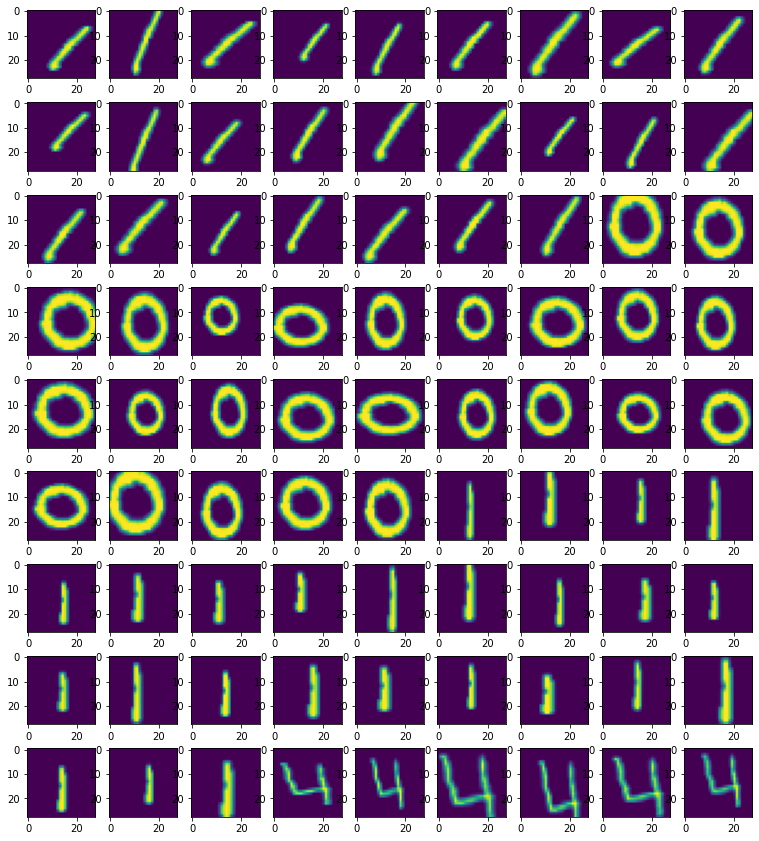

In [69]:
plt.figure(figsize = (13, 15))
for i in range(81):
  plt.subplot(9, 9, i + 1)
  plt.imshow(np.reshape(images[i], (28, 28)))
plt.show()

#Define CNN Model

In [21]:
def res(inputs, filters, strides = 1):
  x = tf.keras.layers.Conv2D(filters, 3, padding = "same")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)
  return x

In [35]:
filters = 64
inputs = tf.keras.layers.Input(shape = (28, 28, 1))
x = res(inputs, filters)
for stack in range(3):
  for block in range(3):
    strides = 1
    if stack > 0 and block ==0:
      strides = 2
    y = res(x, filters, strides = strides)
    y = tf.keras.layers.Conv2D(filters, 3, padding = "same")(y)
    y = tf.keras.layers.BatchNormalization()(y)
    if stack > 0 and block ==0:
      x = tf.keras.layers.Conv2D(filters, 1, padding = "same")(x)
      x = tf.keras.layers.BatchNormalization()(x)
  y = tf.keras.layers.AveragePooling2D()(y)
  x = tf.keras.layers.AveragePooling2D()(x)
  x = tf.keras.layers.average([x, y])
  x = tf.keras.layers.Activation("relu")(x)
  filters*=2
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.Dense(512, activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.Dense(64, activation = "relu")(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.Dense(10, activation = "softmax")(output)
m = tf.keras.models.Model(inputs, output)        

In [36]:
m.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss= "categorical_crossentropy"
              , metrics = ['accuracy'])
m.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 28, 28, 64)   640         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_48 (BatchN  (None, 28, 28, 64)  256         ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 28, 28, 64)   0           ['batch_normalization_48[0]

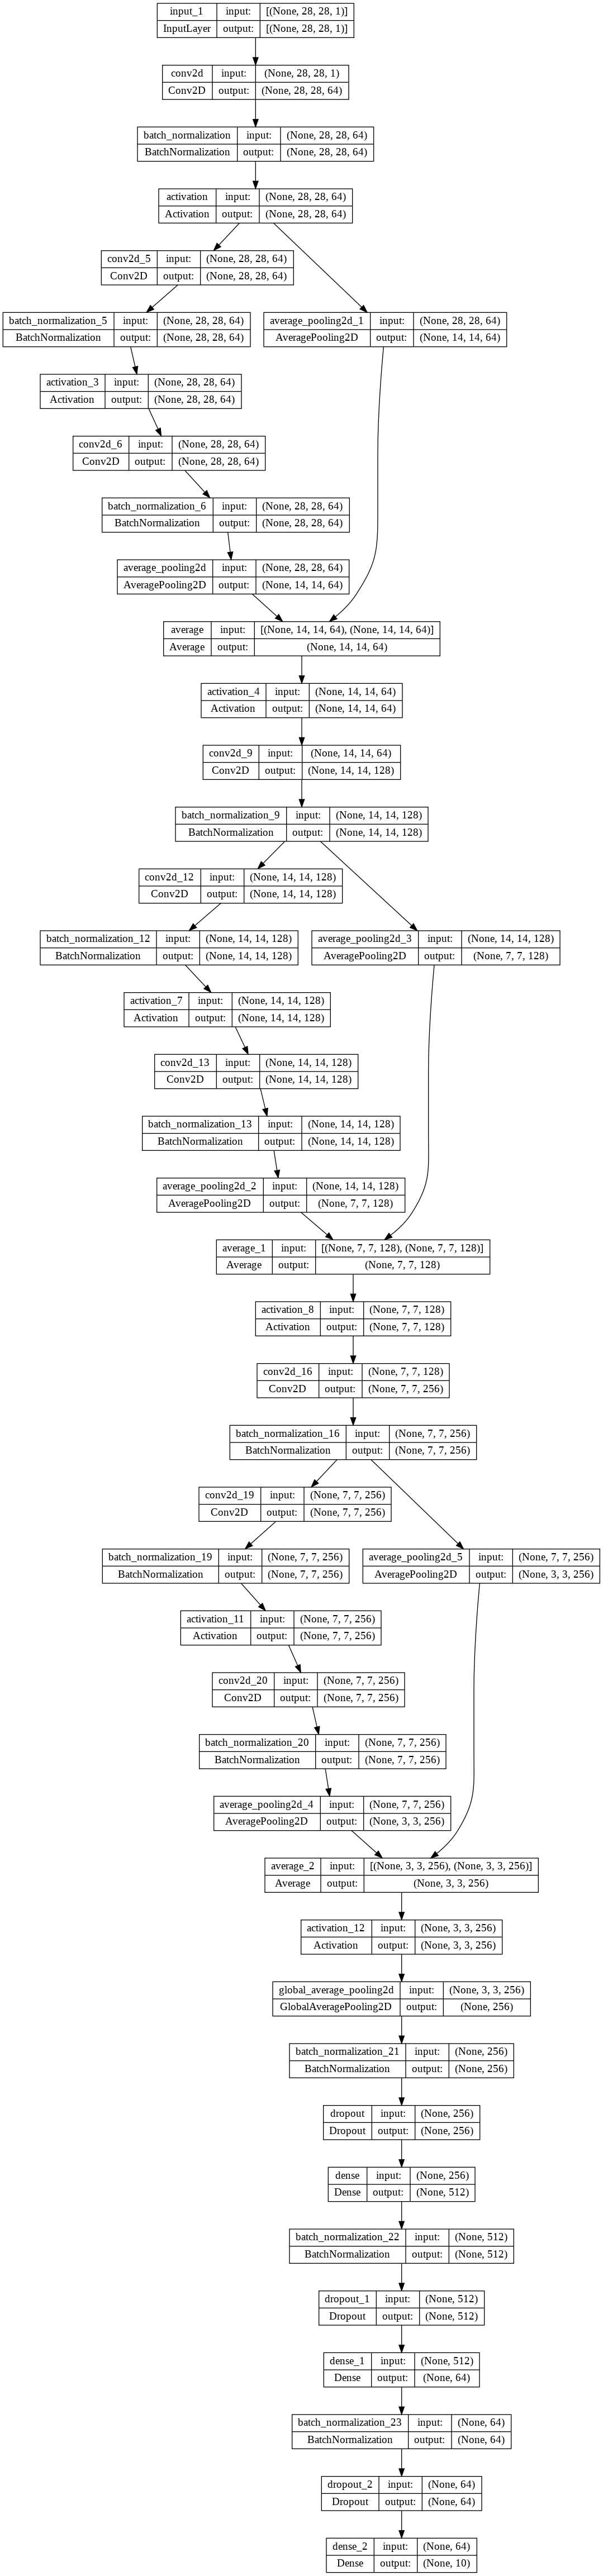

In [24]:
tf.keras.utils.plot_model(m, show_shapes = True)

In [25]:
images.shape

(1050000, 28, 28, 1)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    images, label, test_size=0.2, random_state=True)

In [38]:
history = m.fit(X_train, y_train, batch_size= 32, epochs=100, 
                validation_data = (X_test, y_test),
                callbacks = [tf.keras.callbacks.EarlyStopping(patience= 20, monitor='val_loss', mode = 'min', restore_best_weights=True)])

Epoch 1/100
26250/26250 [==============================] - 359s 14ms/step - loss: 0.0820 - accuracy: 0.9766 - val_loss: 0.0182 - val_accuracy: 0.9946
Epoch 2/100
26250/26250 [==============================] - 356s 14ms/step - loss: 0.0299 - accuracy: 0.9918 - val_loss: 0.0146 - val_accuracy: 0.9959
Epoch 3/100
26250/26250 [==============================] - 355s 14ms/step - loss: 0.0203 - accuracy: 0.9943 - val_loss: 0.0088 - val_accuracy: 0.9974
Epoch 4/100
26250/26250 [==============================] - 355s 14ms/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.0069 - val_accuracy: 0.9981
Epoch 5/100
26250/26250 [==============================] - 356s 14ms/step - loss: 0.0122 - accuracy: 0.9966 - val_loss: 0.0050 - val_accuracy: 0.9986
Epoch 6/100
26250/26250 [==============================] - 355s 14ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.0068 - val_accuracy: 0.9980
Epoch 7/100
26250/26250 [==============================] - 355s 14ms/step - loss: 0.0086 - accuracy:

##Result

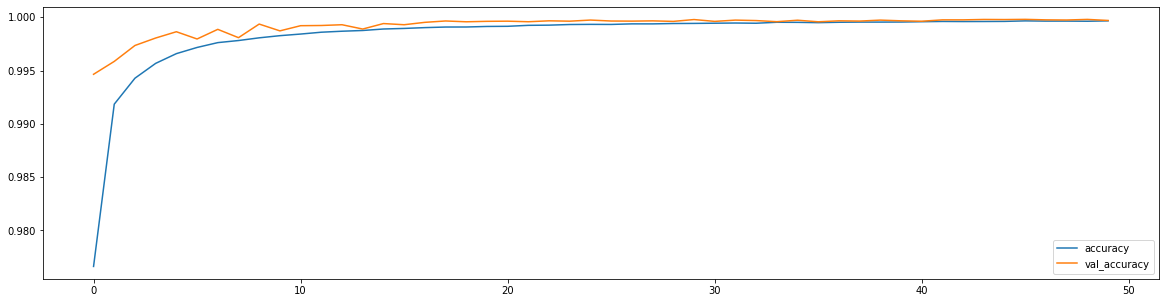

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 5))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()

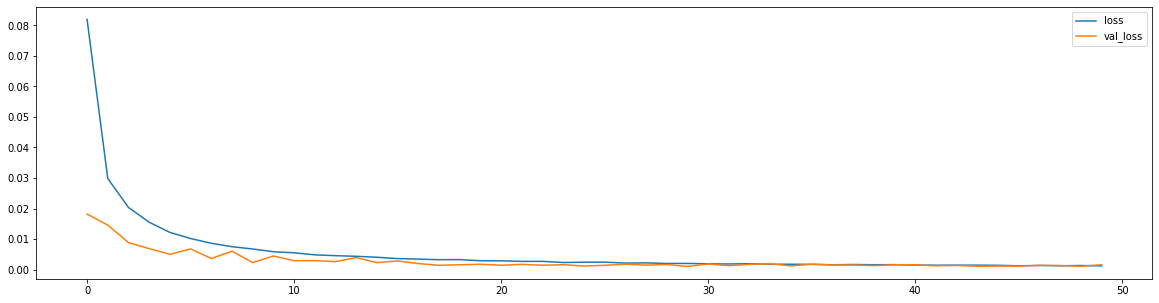

In [40]:
plt.figure(figsize = (20, 5))
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label= "val_loss")
plt.legend()

## Evaluate Model

In [41]:
m.evaluate(X_test, y_test, batch_size= 32)

6563/6563 [==============================] - 37s 6ms/step - loss: 0.0010 - accuracy: 0.9998


[0.0010221502743661404, 0.9997857213020325]

In [42]:
m.evaluate(X_train, y_train, batch_size= 32)

26250/26250 [==============================] - 145s 6ms/step - loss: 9.1495e-05 - accuracy: 1.0000


[9.149510879069567e-05, 0.9999690651893616]

In [43]:
features_test = np.asarray(dataset_test)

In [44]:
features_test.shape

(28000, 784)

In [45]:
features_test = features_test.reshape(features_test.shape[0], 28, 28)

In [46]:
features_test.shape

(28000, 28, 28)

In [48]:
features_test = features_test/255

In [50]:
y_pred = m.predict(features_test)

875/875 [==============================] - 4s 4ms/step


In [51]:
y_pred

array([[5.28920865e-11, 1.57589761e-10, 1.00000000e+00, ...,
        2.48525982e-08, 2.32668355e-12, 8.60083602e-11],
       [1.00000000e+00, 7.84017677e-15, 2.13832051e-16, ...,
        2.66718033e-15, 1.81798597e-14, 1.87498599e-15],
       [1.17749046e-07, 8.34962943e-09, 3.43120837e-06, ...,
        5.59196451e-07, 9.65162812e-08, 9.99994993e-01],
       ...,
       [4.29786957e-13, 5.13438320e-11, 1.69584435e-08, ...,
        3.42116438e-14, 4.95353136e-09, 2.48345206e-10],
       [2.12132807e-12, 7.65625202e-11, 1.44521363e-12, ...,
        5.41169609e-11, 1.67449821e-13, 1.00000000e+00],
       [1.67511727e-10, 8.24183083e-11, 1.00000000e+00, ...,
        5.00835773e-09, 2.09921594e-11, 7.03928249e-10]], dtype=float32)

In [52]:
y_pred = np.argmax(y_pred, axis = 1)

In [53]:
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [59]:
sample_submission = pd.read_csv('digit-recognizer/sample_submission.csv')
sample_submission.Label = y_pred
sample_submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [60]:
sample_submission.to_csv("submission.csv")